머신러닝은 데이터 가공/변환, 모델 학습/예측, 그리고 평가(Evaluation)의 프로세스로 구성

머신러닝 모델은 여러 가지 방법으로 예측 성능을 평가
##### 성능 평가 지표(Evaluation Metric)는 일반적으로 모델이 분류냐 회귀냐에 따라 여러 종류로 나뉨

회귀 : 대부분 실제 값과 예측값의 오차 평균값에 기반    
ex) 오차에 절댓값을 씌운 뒤 평균 오차를 구하거나 오차의 제곱 값에 루트를 씌운 뒤 평균 오차를 구하는 방법과 같이 기본적으로 예측 오차를 가지고 정규화 수준을 재가공하는 방법

분류 : 대부분 실제 결과 데이터와 예측 결과 데이터가 얼마나 정확하고 오류가 적게 발생하는가에 기반하지만 단순히 이러한 정확도만 가지고 판단했다가는 잘못된 평가 결과에 빠질 수 있다.    
ex) 이진 분류 : 0과 1로 결정값이 한정 되는 성능 평가 지표.   
0이냐, 1이냐 혹은 긍정/부정을 판단하는 이진 분류에서는 정확도보다는 다른 성능 평가 지표가 더 중요시되는 경우가 많다.

### 분류의 성능 평가 지표
* 정확도(Accuracy)
* 오차행렬(Confusion Matrix)
* 정밀도(Precision)
* 재현율(Recall)
* F1 스코어
* ROC AUC

# 정확도(Accuracy)

> 정확도(Accuracy) = 예측 결과가 동일한 데이터 건수 / 전체 예측 데이터 건수



In [1]:
# 사이킷런의 BaseEstimator 클래스를 상속받아 아무런 학습을 하지 않고, 성별에 따라 생존자를 예측하는 단순한 Classifier를 생성
# 생성할 MyDummyClassifier 클래스는 학습을 수행하는 fit() 메서드는 아무것도 수행하지 않으며 예측을 수행하는 predict()메서드는
# 단순히 Sex 피처가 1이면 0, 그렇지 않으면 1로 예측하는 매우 단순한 Classifier\

from sklearn.base import BaseEstimator

class MyDummyClassifier(BaseEstimator):
    # fit() 메서드는 아무것도 학습하지 않음
    def fit(self, X, y=None):
        pass
    # predict() 메서드는 단훈히 Sex 피처가 1이면 0, 그렇지 않으면 1로 예측
    def predict(self, X):
        pred = np.zeros((X.shape[0], 1))
        for i in range (X.shape[0]):
            if X['Sex'].iloc[i] == 1:
                pred[i] = 0
            else:
                pred[i] = 1
                
        return pred

In [2]:
from sklearn.preprocessing import LabelEncoder

# Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    return df

# 머신러닝 알고리즘에 불필요한 피처 제거
def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    return df

# 레이블 인코딩 수행.
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

# 앞에서 설정한 데이터 전처리 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 데이터 로딩 및 분할 
titanic_df = pd.read_csv('./titanic_data/train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis = 1)
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size = 0.2, random_state = 0)


# 위에서 생성한 Dummy Classifier를 이용해 학습/예측/평가 수행.
myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)

mypredictions = myclf.predict(X_test)
print('Dummy Classifier의 정확도는: {0:.4f}'.format(accuracy_score(y_test, mypredictions)))

Dummy Classifier의 정확도는: 0.7877


##### 정확도 결과 약 78.77%
불균형한 레이블 값 분포에서 ML 모델의 성능을 판단할 경우 적합한 평가 지표가 아니다.    
ex)
> 100개의 데이터가 있고 이 중에 90개의 데이터 레이블이 0, 단 10개의 데이터 레이블이 1이라고 한다면 무조건 0으로 예측 결과를 반환하는 ML 모델의 경우라도 정확도가 90%가 된다.

#### MNIST 데이터 세트를 변환해 불균형한 데이터 세트로 만든 뒤에 정확도 지표 적용 시 어떤 문제가 발생할 수 있는지 살펴보기

* MNIST 데이터 세트는 0부터 9까지의 숫자 이미지의 픽셀 정보를 가지고 있으며, 이를 기반으로 숫자 Digit를 예측하는데 사용
* 사이킷런은 load_digits() API를 통해 MNIST 데이터 세트를 제공
* MNIST는 레이블 값이 0부터 9까지 있는 멀티 레이블 분류를 위한 것

이를 레이블 값이 7인 것만 True, 나머지 값은 False로 변환해 이진 분류 문제로 살짝 바꿔 보겠습니다.   
즉, 전체 데이터의 10%만 True, 나머지90%는 False인 불균형한 데이터 세트로 변형

In [4]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

class MyFakeClassifier(BaseEstimator):
    def fit(self,X,y):
        pass
    
    # 입력값으로 들어오는 X 데이터 셋의 크기만큼 모두 0값으로 만들어서 반환
    def predict(self,X):
        return np.zeros( (len(X), 1) , dtype=bool)

# 사이킷런의 내장 데이터 셋인 load_digits( )를 이용하여 MNIST 데이터 로딩
digits = load_digits()

print(digits.data)
print("### digits.data.shape:", digits.data.shape)
print(digits.target)
print("### digits.target.shape:", digits.target.shape)



# digits번호가 7번이면 True이고 이를 astype(int)로 1로 변환, 7번이 아니면 False이고 0으로 변환. 
y = (digits.target == 7).astype(int)
X_train, X_test, y_train, y_test = train_test_split( digits.data, y, random_state=11)

[[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  0. ... 10.  0.  0.]
 [ 0.  0.  0. ... 16.  9.  0.]
 ...
 [ 0.  0.  1. ...  6.  0.  0.]
 [ 0.  0.  2. ... 12.  0.  0.]
 [ 0.  0. 10. ... 12.  1.  0.]]
### digits.data.shape: (1797, 64)
[0 1 2 ... 8 9 8]
### digits.target.shape: (1797,)


In [5]:
# 불균형한 레이블 데이터 분포도 확인. 
print('레이블 테스트 세트 크기 :', y_test.shape)
print('테스트 세트 레이블 0 과 1의 분포도')
print(pd.Series(y_test).value_counts())

# Dummy Classifier로 학습/예측/정확도 평가
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train , y_train)
fakepred = fakeclf.predict(X_test)
print('모든 예측을 0으로 하여도 정확도는:{:.3f}'.format(accuracy_score(y_test , fakepred)))

레이블 테스트 세트 크기 : (450,)
테스트 세트 레이블 0 과 1의 분포도
0    405
1     45
dtype: int64
모든 예측을 0으로 하여도 정확도는:0.900


##### 정확도 90%
##### 이처럼 정확도 평가 지표는 불균형한 레이블 데이터 세트에서는 성능 수치로 사용돼서는 안됨
정확도가 가지는 분류 평가 지표로서 이러한 한계점을 극복하기 위해 여러 가지 분류 지표와 함께 적용하여 ML 모델 성능을 평가해야 한다.

# 오차 행렬
> 이진 분류에서 성능 지표로 잘 활용되는 오차행렬(confusion matrix, 혼동행렬)은 학습된 분류 모델이 예측을 수행하면서 얼마나 헷갈리고(confused) 있는지도 함께 보여주는 지표

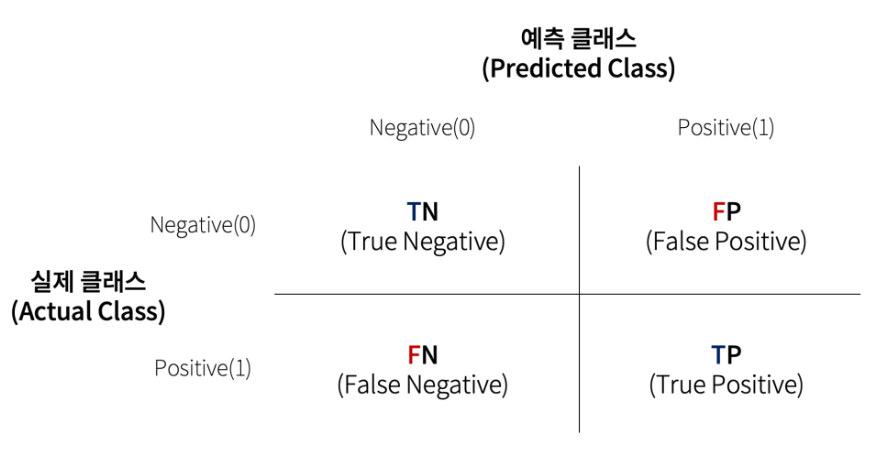

* TN : 예측값을 Negative 값 0으로 예측했고 실제 값 Negative 값 0
* FP : 예측값을 Positive 값 1으로 예측했고 실제 값 Negative 값 0
* FN : 예측값을 Negative 값 0으로 예측했고 실제 값 Positive 값 1
* TN : 예측값을 Positive 값 1으로 예측했고 실제 값 Negative 값 1

In [6]:
from sklearn.metrics import confusion_matrix

# 앞절의 예측 결과인 fakepred와 실제 결과인 y_test의 Confusion Matrix출력
confusion_matrix(y_test , fakepred)

array([[405,   0],
       [ 45,   0]], dtype=int64)

* TN = 405
* FP = 0
* FN = 45
* TP = 0

앞에서 소개한 정확도는 예측값과 실제 값이 얼마나 동일한가에 대한 비율만으로 결정
> 오차 행렬에서 True에 해당하는 값인 TN과 TP에 좌우 된다.
##### 정확도 = 예측 결과와 실제 값이 동일한 건수 / 전체 데이터 수 = (TN + TP)/(TN + FP + FN + TP)

정확도는 분류 모델의 성능을 측정할 수 있는 한 가지 요소일 뿐.
불균형한 데이터 세트에서 정확도만으로 모델 신뢰도가 떨어질 수 있는 사례를 보았고, 불균형한 데이터 세트에서 정확도보다 더 선호되는 평가 지표인 정밀도(Precision)와 재현율(Recall)에 대해 알아보기

# 정밀도와 재현율

##### 정밀도 = TP / (FP + TP)
> 예측을 positive로 한 대상중에 예측과 실제 값이 positive로 일치한 데이터의 비율
##### 재현율 = TP / (FN + TP)
> 실제 값이 positive인 대상 중 예측과 실제 값이 positive로 일치한 데이터의 비율
* 재현율이 상대적으로 더 중요한 지표인 경우는 실제 Positive 양성인 데이터 예측을 Negative로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우
* 정밀도가 상대적으로 더 중요한 지표인 경우는 실제 Negative 음성인 데이터 예측을 Positive 양성으로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우

In [7]:
# 오차행렬, 정확도, 정밀도, 재현율을 한꺼번에 계산하는 함수 생성
from sklearn.metrics import accuracy_score, precision_score , recall_score , confusion_matrix

def get_clf_eval(y_test , pred):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    print('오차 행렬')

    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}'.format(accuracy , precision ,recall))

In [8]:
# 로지스틱 회귀 기반으로 타이타닉 생존자 예측 및 혼동 행렬, 정확도, 정밀도, 재현율 출력
# LogisticRegression
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression

# 원본 데이터를 재로딩, 데이터 가공, 학습데이터/테스트 데이터 분할. 
titanic_df = pd.read_csv('./titanic_data/train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df= titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, \
                                                    test_size=0.20, random_state=11)

lr_clf = LogisticRegression(solver='liblinear')

lr_clf.fit(X_train , y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test , pred)

오차 행렬
[[108  10]
 [ 14  47]]
정확도: 0.8659, 정밀도: 0.8246, 재현율: 0.7705


### 정밀도/재현율 트레이드오프
분류하려는 업무의 특성상 정밀도 또는 재현율이 특별히 강조돼야 할 경우 분류의 결정 임곗값을 조정해 정밀도 또는 재현율의 수치를 높이는 방법

#### 임계값 조정 predict_proba() 메소드 활용

In [9]:
pred_proba = lr_clf.predict_proba(X_test)
pred  = lr_clf.predict(X_test)
print('pred_proba()결과 Shape : {0}'.format(pred_proba.shape))
print('pred_proba array에서 앞 3개만 샘플로 추출 \n:', pred_proba[:3])

# 예측 확률 array 와 예측 결과값 array 를 concatenate 하여 예측 확률과 결과값을 한눈에 확인
pred_proba_result = np.concatenate([pred_proba , pred.reshape(-1,1)],axis=1)
print('두개의 class 중에서 더 큰 확률을 클래스 값으로 예측 \n',pred_proba_result[:3])

pred_proba()결과 Shape : (179, 2)
pred_proba array에서 앞 3개만 샘플로 추출 
: [[0.44935227 0.55064773]
 [0.86335512 0.13664488]
 [0.86429645 0.13570355]]
두개의 class 중에서 더 큰 확률을 클래스 값으로 예측 
 [[0.44935227 0.55064773 1.        ]
 [0.86335512 0.13664488 0.        ]
 [0.86429645 0.13570355 0.        ]]


#### 임계값 조정 Binarizer 활용

In [10]:
from sklearn.preprocessing import Binarizer

X = [[ 1, -1,  2],
     [ 2,  0,  0],
     [ 0,  1.1, 1.2]]

# threshold 기준값보다 같거나 작으면 0을, 크면 1을 반환
binarizer = Binarizer(threshold=1.1)                     
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [11]:
from sklearn.preprocessing import Binarizer

#Binarizer의 threshold 설정값. 분류 결정 임곗값임.  
custom_threshold = 0.5

# predict_proba( ) 반환값의 두번째 컬럼 , 즉 Positive 클래스 컬럼 하나만 추출하여 Binarizer를 적용
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1) 
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[108  10]
 [ 14  47]]
정확도: 0.8659, 정밀도: 0.8246, 재현율: 0.7705


In [12]:
# Binarizer의 threshold 설정값을 0.4로 설정. 즉 분류 결정 임곗값을 0.5에서 0.4로 낮춤  
custom_threshold = 0.4
pred_proba_1 = pred_proba[:,1].reshape(-1,1)
binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1) 
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test , custom_predict)

오차 행렬
[[97 21]
 [11 50]]
정확도: 0.8212, 정밀도: 0.7042, 재현율: 0.8197


##### 임계값을 낮추면 재현율이 올라가고 정밀도는 떨어진다.

In [13]:
# 테스트를 수행할 모든 임곗값을 리스트 객체로 저장. 
thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]

def get_eval_by_threshold(y_test , pred_proba_c1, thresholds):
    # thresholds list객체내의 값을 차례로 iteration하면서 Evaluation 수행.
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1) 
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값:',custom_threshold)
        get_clf_eval(y_test , custom_predict)

get_eval_by_threshold(y_test ,pred_proba[:,1].reshape(-1,1), thresholds )

임곗값: 0.4
오차 행렬
[[97 21]
 [11 50]]
정확도: 0.8212, 정밀도: 0.7042, 재현율: 0.8197
임곗값: 0.45
오차 행렬
[[105  13]
 [ 13  48]]
정확도: 0.8547, 정밀도: 0.7869, 재현율: 0.7869
임곗값: 0.5
오차 행렬
[[108  10]
 [ 14  47]]
정확도: 0.8659, 정밀도: 0.8246, 재현율: 0.7705
임곗값: 0.55
오차 행렬
[[111   7]
 [ 16  45]]
정확도: 0.8715, 정밀도: 0.8654, 재현율: 0.7377
임곗값: 0.6
오차 행렬
[[113   5]
 [ 17  44]]
정확도: 0.8771, 정밀도: 0.8980, 재현율: 0.7213


In [14]:
from sklearn.metrics import precision_recall_curve

# 레이블 값이 1일때의 예측 확률을 추출 
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1] 

# 실제값 데이터 셋과 레이블 값이 1일 때의 예측 확률을 precision_recall_curve 인자로 입력 
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1 )
print('반환된 분류 결정 임곗값 배열의 Shape:', thresholds.shape)
print('반환된 precisions 배열의 Shape:', precisions.shape)
print('반환된 recalls 배열의 Shape:', recalls.shape)

print("thresholds 5 sample:", thresholds[:5])
print("precisions 5 sample:", precisions[:5])
print("recalls 5 sample:", recalls[:5])

#반환된 임계값 배열 로우가 147건이므로 샘플로 10건만 추출하되, 임곗값을 15 Step으로 추출. 
thr_index = np.arange(0, thresholds.shape[0], 15)
print('샘플 추출을 위한 임계값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임곗값: ', np.round(thresholds[thr_index], 2))

# 15 step 단위로 추출된 임계값에 따른 정밀도와 재현율 값 
print('샘플 임계값별 정밀도: ', np.round(precisions[thr_index], 3))
print('샘플 임계값별 재현율: ', np.round(recalls[thr_index], 3))

반환된 분류 결정 임곗값 배열의 Shape: (165,)
반환된 precisions 배열의 Shape: (166,)
반환된 recalls 배열의 Shape: (166,)
thresholds 5 sample: [0.01974988 0.06956414 0.08402808 0.08474207 0.08920161]
precisions 5 sample: [0.34078212 0.34269663 0.34463277 0.34659091 0.34857143]
recalls 5 sample: [1. 1. 1. 1. 1.]
샘플 추출을 위한 임계값 배열의 index 10개: [  0  15  30  45  60  75  90 105 120 135 150]
샘플용 10개의 임곗값:  [0.02 0.11 0.13 0.14 0.16 0.24 0.32 0.45 0.62 0.73 0.87]
샘플 임계값별 정밀도:  [0.341 0.372 0.401 0.44  0.505 0.598 0.688 0.774 0.915 0.968 0.938]
샘플 임계값별 재현율:  [1.    1.    0.967 0.902 0.902 0.902 0.869 0.787 0.705 0.492 0.246]


### 임계값 변화에 따른 평가 지표 값 제공해주는 API - precision_recall_curve_plot(y_true, probas_pred)

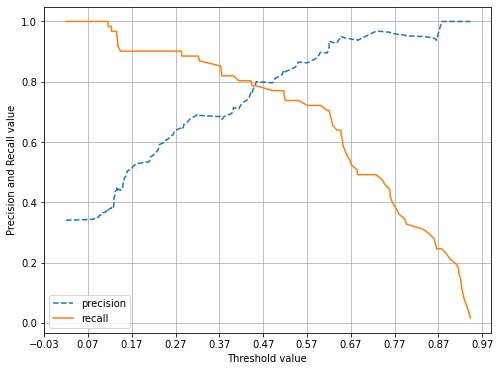

In [15]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
    
precision_recall_curve_plot( y_test, lr_clf.predict_proba(X_test)[:, 1] )

##### 그래프에서 직관적으로 확인. 한 수치를 강조하기 위해 임계값을 조정할 수 있지만, 하나만을 과도하게 강조하는 것은 좋지 않다.

# F1 스코어
F1 스코어(Score)는 정밀도와 재현율을 결합한 지표.
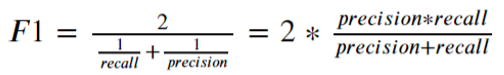

In [16]:
from sklearn.metrics import f1_score 
f1 = f1_score(y_test , pred)
print('F1 스코어: {0:.4f}'.format(f1))

F1 스코어: 0.7966


In [17]:
# 임계값을 변화시키며, 정확도, 정밀도, 재현율, F1 Score값을 모두 확인
def get_clf_eval(y_test , pred):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    # F1 스코어 추가
    f1 = f1_score(y_test,pred)
    print('오차 행렬')
    print(confusion)
    # f1 score print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}'.format(accuracy, precision, recall, f1))

thresholds = [0.4 , 0.45 , 0.50 , 0.55 , 0.60]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

임곗값: 0.4
오차 행렬
[[97 21]
 [11 50]]
정확도: 0.8212, 정밀도: 0.7042, 재현율: 0.8197, F1:0.7576
임곗값: 0.45
오차 행렬
[[105  13]
 [ 13  48]]
정확도: 0.8547, 정밀도: 0.7869, 재현율: 0.7869, F1:0.7869
임곗값: 0.5
오차 행렬
[[108  10]
 [ 14  47]]
정확도: 0.8659, 정밀도: 0.8246, 재현율: 0.7705, F1:0.7966
임곗값: 0.55
오차 행렬
[[111   7]
 [ 16  45]]
정확도: 0.8715, 정밀도: 0.8654, 재현율: 0.7377, F1:0.7965
임곗값: 0.6
오차 행렬
[[113   5]
 [ 17  44]]
정확도: 0.8771, 정밀도: 0.8980, 재현율: 0.7213, F1:0.8000


# ROC곡선과 AUC
이진 분류 평가를 위한 평가 지표

### ROC곡선 
> FPR(False Positive Rate)이 변할 때 TPR(True Positive Rate)이 어떻게 변하는지를 나타내는 곡선
* TPR == 재현율 = TP/(TP+FN)
* FPR = FP/(FP+TN) = 1-TNR = 1-특이성

### AUC
> ROC곡선 밑의 넓이     
1에 가까울 수록 좋은 수치

In [18]:
from sklearn.metrics import roc_curve

# 레이블 값이 1일때의 예측 확률을 추출 
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1] 

fprs , tprs , thresholds = roc_curve(y_test, pred_proba_class1)
# 반환된 임곗값 배열에서 샘플로 데이터를 추출하되, 임곗값을 5 Step으로 추출. 
# thresholds[0]은 max(예측확률)+1로 임의 설정됨. 이를 제외하기 위해 np.arange는 1부터 시작
thr_index = np.arange(1, thresholds.shape[0], 5)
print('샘플 추출을 위한 임곗값 배열의 index:', thr_index)
print('샘플 index로 추출한 임곗값: ', np.round(thresholds[thr_index], 2))

# 5 step 단위로 추출된 임계값에 따른 FPR, TPR 값
print('샘플 임곗값별 FPR: ', np.round(fprs[thr_index], 3))
print('샘플 임곗값별 TPR: ', np.round(tprs[thr_index], 3))

샘플 추출을 위한 임곗값 배열의 index: [ 1  6 11 16 21 26 31 36 41 46]
샘플 index로 추출한 임곗값:  [0.94 0.73 0.62 0.52 0.44 0.28 0.15 0.14 0.13 0.12]
샘플 임곗값별 FPR:  [0.    0.008 0.025 0.076 0.127 0.254 0.576 0.61  0.746 0.847]
샘플 임곗값별 TPR:  [0.016 0.492 0.705 0.738 0.803 0.885 0.902 0.951 0.967 1.   ]


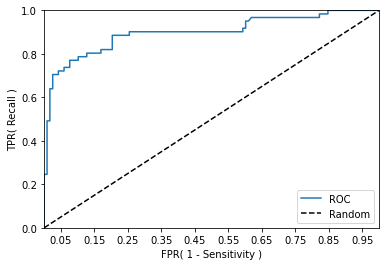

In [19]:
def roc_curve_plot(y_test , pred_proba_c1):
    # 임곗값에 따른 FPR, TPR 값을 반환 받음. 
    fprs , tprs , thresholds = roc_curve(y_test ,pred_proba_c1)

    # ROC Curve를 plot 곡선으로 그림. 
    plt.plot(fprs , tprs, label='ROC')
    # 가운데 대각선 직선을 그림. 
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    
    # FPR X 축의 Scale을 0.1 단위로 변경, X,Y 축명 설정등   
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel('FPR( 1 - Sensitivity )'); plt.ylabel('TPR( Recall )')
    plt.legend()
    plt.show()
    
roc_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1] )

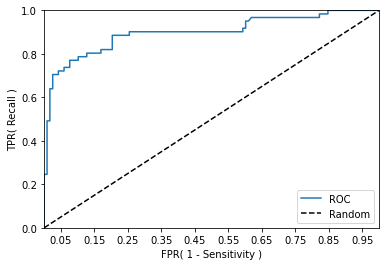

ROC AUC 값: 0.8987


In [20]:
def roc_curve_plot(y_test , pred_proba_c1):
    # 임곗값에 따른 FPR, TPR 값을 반환 받음. 
    fprs , tprs , thresholds = roc_curve(y_test ,pred_proba_c1)

    # ROC Curve를 plot 곡선으로 그림. 
    plt.plot(fprs , tprs, label='ROC')
    # 가운데 대각선 직선을 그림. 
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    
    # FPR X 축의 Scale을 0.1 단위로 변경, X,Y 축명 설정등   
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel('FPR( 1 - Sensitivity )'); plt.ylabel('TPR( Recall )')
    plt.legend()
    plt.show()
    
roc_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1] )
from sklearn.metrics import roc_auc_score
pred_proba = lr_clf.predict_proba(X_test)[:, 1]
roc_score = roc_auc_score(y_test, pred_proba)
print('ROC AUC 값: {0:.4f}'.format(roc_score))